In [1]:
import(Optim)
import(JSON)
import(Plots)

In [2]:
using(BenchmarkTools)

In [9]:
mutable struct Graph
    chains::Array{Array{String,1},1}
    nodes::Dict{String,Int64}
    coords::Union{Nothing, Array{Float64,2}}
end

# from node key (string) to index, to coords
function get_coords(graph, n)
    return graph.coords[[1, 2], graph.nodes[n]]
    end;

function printinfo(x::Graph)
    println(length(x.nodes), " nodes")
    println(length(x.chains), " chains")
    end;

# Graph the graph
function graphplot(graph::Graph)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in graph.chains
        chain_xy = map(x -> graph.coords[[1, 2], graph.nodes[x]], chain);
        x = getindex.(chain_xy, 1)
        y = getindex.(chain_xy, 2)
        Plots.plot!(x, y, linewidth=3)
        #println(coords[idx, 1])
        end;
    fig
    end;

# Define the (entire) graph
function init_graph_from_chains(chains)
    nodes_list = unique(n for ch in chains for n in ch)
    nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )

    fullgraph = Graph(chains, nodes, nothing);
    end;

In [325]:
# ====================
# Load graph from Json
files = filter(x -> endswith(x, ".json"), readdir("json/"))

println(files)

path = string("./json/", files[4])
data = read(path, String)
d = []
chains = JSON.parse( data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println("number of chains: ", length(chains))

["069833931_1557.json", "069833931_2343.json", "069833931_812.json", "083809252_139.json", "224700774_111.json"]
number of chains: 17


In [292]:
# test graph
chains = [["A", "B", "C", "D", "E", "ez", "zra"],
    ["R", "E", "T", "ER", "erz", "ZE"]]#, ["E", "F", "G"]]#, ["A", "1", "2", "G"]]

2-element Array{Array{String,1},1}:
 ["A", "B", "C", "D", "E", "ez", "zra"]
 ["R", "E", "T", "ER", "erz", "ZE"]    

In [326]:
graph = init_graph_from_chains(chains);
printinfo(graph)

151 nodes
17 chains


In [328]:
# init coords
N = length(graph.nodes)
radius = N/(2*pi)
graph.coords = hcat([[radius*cos(k*2*pi/N); radius*sin(k*2*pi/N)] for k in 1:N]...);
# gradient
G = zeros(Float32, size(coords)...);

In [329]:
res = optimize!(graph)

 * Status: success

 * Candidate solution
    Minimizer: [2.37e+01, 3.56e+00, 2.23e+01,  ...]
    Minimum:   6.767481e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [2.40e+01, 1.00e+00, 2.39e+01,  ...]

 * Convergence measures
    |x - x'|               = 3.38e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.75e-11 ≰ 0.0e+00
    |g(x)|                 = 9.10e-05 ≤ 1.0e-04

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    820
    f(x) calls:    2508
    ∇f(x) calls:   2508


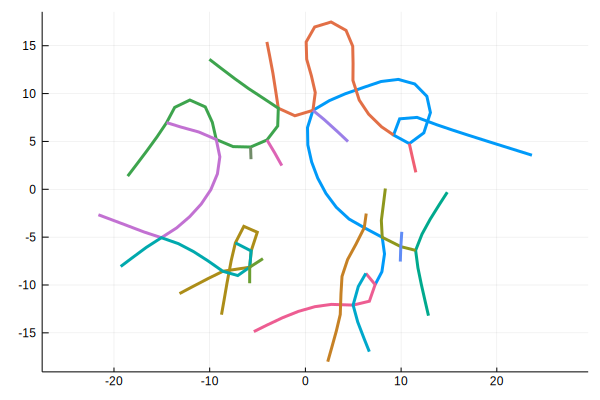

In [330]:
graphplot(graph)

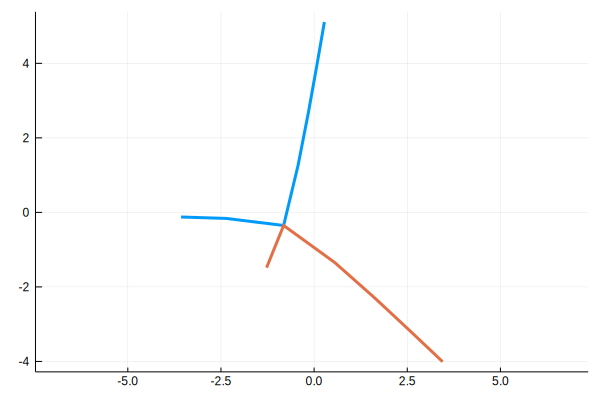

In [259]:
graphplot(graph)

In [222]:
function optimize!(graph)
    coords = copy(graph.coords)
    G = zeros(Float32, size(coords)...)
    result = Optim.optimize(x->graph_energy(x, graph),
                            (G, x)->graph_gradient!(G, x, graph),
                            coords, #Optim.GradientDescent(),
                             Optim.Options(g_tol = 1e-4,
                                           iterations = 1000,
                                           store_trace = false,
                                           show_trace = false)
    )

    # convert back to a "normal" graph
    graph.coords = result.minimizer;
    result
    end;


In [288]:
## Force Layout 

# Spring
function attractive_gradient(u, v)
    return (-u, -v)
    end;
function attractive_energy(u, v)
    return (u^2 + v^2)/2
    end;

# Elec
const EPSILON = 1e-4
function low_repulsive_energy(u, v)
    return 1/sqrt(u^2 + v^2 + EPSILON)*10
    end;

function low_repulsive_gradient(u, v)
    d = sqrt(u^2 + v^2 + EPSILON)^3/10
    return (u/d, v/d)
    end;

# Reversed Gravity
const EPSILON = 1e-4
function repulsive_energy(u, v)
    return 1/(u^2 + v^2 + EPSILON)^2
    end;

function repulsive_gradient(u, v)
    d4 = (u^2 + v^2 + EPSILON)^3
    return (4*u/d4, 4*v/d4)
    end;


# d/dx(-1/sqrt(x^2 + y^2)) = x/(x^2 + y^2)^(3/2)

function graph_gradient!(G, coords, graph)
    fill!(G, 0.f0)
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            grad = attractive_gradient(u, v)
            G[1, i1] += grad[1]
            G[2, i1] += grad[2]
            G[1, i2] -= grad[1]
            G[2, i2] -= grad[2]
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            grad = repulsive_gradient(u, v)
            G[1, i] += grad[1]
            G[2, i] += grad[2]
            G[1, j] -= grad[1]
            G[2, j] -= grad[2]
            end;
        end;
    
        # Moment
    for chain in graph.chains
        for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
            i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
            x1, y1 = coords[1, i1], coords[2, i1]
            #x2, y2 = coords[1, i2], coords[2, i2]
            x3, y3 = coords[1, i3], coords[2, i3]
            #u12 = x2 - x1
            #v12 = y2 - y1
            u13 = x3 - x1
            v13 = y3 - y1
            
            grad = low_repulsive_gradient(u13, v13)
            G[1, i1] += grad[1]
            G[2, i1] += grad[2]
            G[1, i3] -= grad[1]
            G[2, i3] -= grad[2]
            end
    end
    
    end;

function graph_energy(coords, graph)
    E = 0
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            E += attractive_energy(u, v)
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            E += repulsive_energy(u, v)
            end;
        end;

    # Moment
    for chain in graph.chains
        for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
            i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
            x1, y1 = coords[1, i1], coords[2, i1]
            #x2, y2 = coords[1, i2], coords[2, i2]
            x3, y3 = coords[1, i3], coords[2, i3]
            #u12 = x2 - x1
            #v12 = y2 - y1
            u13 = x3 - x1
            v13 = y3 - y1
            
            E += low_repulsive_energy(u13, v13)

            end
    end
    
    return E
    end;



In [ ]:
    # Moment
    for chain in graph.chains
        for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
            i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            x3, y3 = coords[1, i3], coords[2, i3]
            u12 = x2 - x1
            v12 = y2 - y1
            u23 = x3 - x1
            v23 = y3 - y2
            
            d12_sq = u12^2 + v12^2
            d23_sq = u23^2 + v23^2

            dot = u12*u23 + v12*v23
            
            E -= 35.0*dot/sqrt(d12_sq*d23_sq + EPSILON)
            end
    end

In [82]:
E = 0.0
for chain in graph.chains
    for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
        i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
        x1, y1 = coords[1, i1], coords[2, i1]
        x2, y2 = coords[1, i2], coords[2, i2]
        x3, y3 = coords[1, i3], coords[2, i3]
        #u12 = x2 - x1
        v12 = y2 - y1
        #u23 = x3 - x1
        v23 = y3 - y2
        u13 = x3 - x1
        E += 1 - v12*v23./(sqrt(u13^2 + v12^2 + EPSILON)*abs(v23 + EPSILON))
    end
end

In [83]:
E

77.26646687479513